In [1]:
import numpy as np
import matplotlib.pyplot as plt

from delimitpy import parse_input
from delimitpy import process_empirical
from delimitpy import generate_models
from delimitpy import simulate_data
from delimitpy import build_predictors

2024-04-06 09:10:15.237835: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# delimitpy walk-through

This jupyter notebook walks through each step in running delimitpy, including parsing and reading input data, building SFS, building models, simulating data, training machine learning models, and applying models to empirical data.

## Step 1: Parse the configuration file

We will use the ModelConfigParser class to parse the information from the configuration. A full description of the configuration file, along with an example, is available [here](https://delimitpy.readthedocs.io/en/latest/usage/parsinginput.html). This file provides delimitpy with the information it needs to conduct a species delimitation analysis. 

In [2]:
config_parser = parse_input.ModelConfigParser("../input_files/config.txt")
config_values = config_parser.parse_config()

## Step 2: Process empirical data

Next, we will process our empirical data. The format for the empirical data is described in detail [here](https://delimitpy.readthedocs.io/en/latest/usage/parsinginput.html). 

There are three major steps:
1) Read data from fasta files and convert to a numpy array.
2) Choose values for down-projecting the Site Frequency Spectrum.
3) Build SFS with down-projection.
4) Determine the average number of SNPs used to construct the SFS.


### Step 2a: Read data into numpy array

In [3]:
data_processor = process_empirical.DataProcessor(config=config_values)
empirical_array = data_processor.fasta_to_numpy()
print(f"Our input data has {empirical_array.shape[0]} individuals and {empirical_array.shape[1]} SNPs.")

Our input data has 60 individuals and 1053 SNPs.


### Step 2b: Choose values for down-projection

SFS cannot be generated from datasets that include missing data. To circumvent this, we use a downsampling approach such as that described in Satler and Carstens [(2017)](https://doi.org/10.1111/mec.14137). We must choose thresholds for each populations (i.e., the minumum number of individuals that must be sampled for a SNP to be used.) To help with this, we use the function find_downsampling from the class DataProcessor. This function generates a dictionary that holds the number of SNPs that meet each threshold.

We will use a folded SFS, meaning that we will build the SFS based on minor allele frequencies.

Since our data should be phased, and we will simulate diploid individuals, we will only consider multiples of 2.

In [4]:
# generate dictionary with the number of SNPs at different sampling thresholds
empirical_2d_sfs_sampling = data_processor.find_downsampling(empirical_array)

# print threshold, SNP combos for thresholds with at least 1030 snps
minspns = 1030
min_filtered = {key: value for key, value in empirical_2d_sfs_sampling.items() if value >= minspns}
print(min_filtered)


{(20, 20, 20): 1053, (20, 20, 18): 1053, (20, 20, 16): 1053, (20, 20, 14): 1053, (20, 20, 12): 1053, (20, 20, 10): 1053, (20, 20, 8): 1053, (20, 20, 6): 1053, (20, 20, 4): 1053, (20, 20, 2): 1053, (20, 18, 20): 1053, (20, 18, 18): 1053, (20, 18, 16): 1053, (20, 18, 14): 1053, (20, 18, 12): 1053, (20, 18, 10): 1053, (20, 18, 8): 1053, (20, 18, 6): 1053, (20, 18, 4): 1053, (20, 18, 2): 1053, (20, 16, 20): 1053, (20, 16, 18): 1053, (20, 16, 16): 1053, (20, 16, 14): 1053, (20, 16, 12): 1053, (20, 16, 10): 1053, (20, 16, 8): 1053, (20, 16, 6): 1053, (20, 16, 4): 1053, (20, 16, 2): 1053, (20, 14, 20): 1053, (20, 14, 18): 1053, (20, 14, 16): 1053, (20, 14, 14): 1053, (20, 14, 12): 1053, (20, 14, 10): 1053, (20, 14, 8): 1053, (20, 14, 6): 1053, (20, 14, 4): 1053, (20, 14, 2): 1053, (20, 12, 20): 1053, (20, 12, 18): 1053, (20, 12, 16): 1053, (20, 12, 14): 1053, (20, 12, 12): 1053, (20, 12, 10): 1053, (20, 12, 8): 1053, (20, 12, 6): 1053, (20, 12, 4): 1053, (20, 12, 2): 1053, (20, 10, 20): 1053,

### Step 2c: Build SFS with down-projection

We want to maximize the number of individuals and SNPs we can use. In this tutorial, since the input data were simulated without missing data, we can use all individuals and still retain all the SNPs.

Now, we are ready to build our SFS. We are only using a single replicate for this test. This makes sense because our ‘empirical’ data are actually simulated data, and we are not downsampling. Because of this, we do not expect much noise. For messier empirical data, use ~10 reps and ensure that results do not differ across replicates.

We will build a set of joint SFS (jSFS) between each pairwise combination of populations. Additionally, we will build a multidimensional SFS (mSFS). When building the mSFS, we can optionally choose to use a binning approach [(Smith et al., 2018)](https://doi.org/10.1111/mec.14223). This creates a coarser SFS, which can be helpful if we have a lot of individuals and not that many SNPs.

The code below will also print the number of SNPs used on average to construct the mSFS, which will be helpful information when deciding how many SNPs to use to build the SFS for the simulated data.

In [5]:
downsampling_dictionary = {"A":20, "B":20, "C":20}

# build 10 replicates of the 2d SFS
empirical_2d_sfs = data_processor.numpy_to_2d_sfs(empirical_array, downsampling=downsampling_dictionary, replicates = 1)

# build 10 replicates of the mSFS
empirical_msfs, average_snps = data_processor.numpy_to_msfs(empirical_array, downsampling=downsampling_dictionary, replicates = 1)

We used an average of 1009 to construct the mSFS.


## Step 3: Build the models, and draw parameters from priors

Next, we will use functions from the ModelBuilder class to generate a baseline set of models (without parameters). Then, we use draw_parameters to draw parameterized models from the parameter space. This will return a lists of lists. Each list will correspond to a model. For each model, we have a list of parameterized versions of that model, with parameters drawn from the priors defined by the user in the configuration and species tree files.

A full description of the models generated by delimitpy is available [here](https://delimitpy.readthedocs.io/en/latest/usage/buildingmodels.html).

In [6]:
# build the models
model_builder = generate_models.ModelBuilder(config_values)
divergence_demographies, sc_demographies, dwg_demographies = model_builder.build_models()

# parameterize the models
parameterized_models, labels = model_builder.draw_parameters(divergence_demographies, sc_demographies, dwg_demographies)

print((f"Number of models: {len(parameterized_models)}"))
print((f"Number of replicates: {len(parameterized_models[0])}"))

INFO:delimitpy.generate_models:Creating 5 different models based on user input.


Number of models: 5
Number of replicates: 1000


## Step 4: Validate the models by  plotting

Now, we must ask "Are these the models I'm looking for?"

One way to easily check this is by plotting the models. The validate_models function takes as input your lists returned from the parameterization command above (draw_parameters). For each model, it will draw one parameterization at random, and plot it using functionality from the drawdemes package.

Make sure the models look like you hoped they would! Remember, you are only seeing a single parameterization for each model.

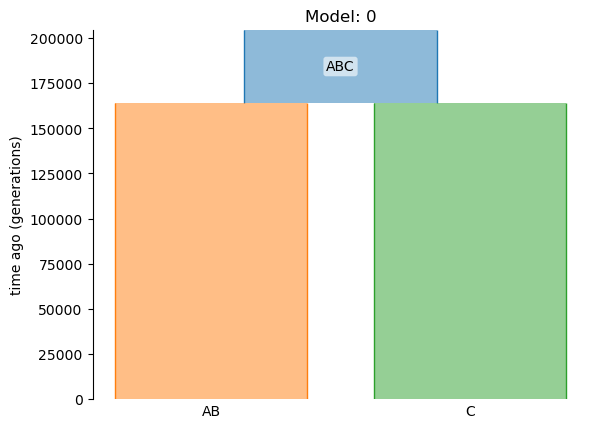

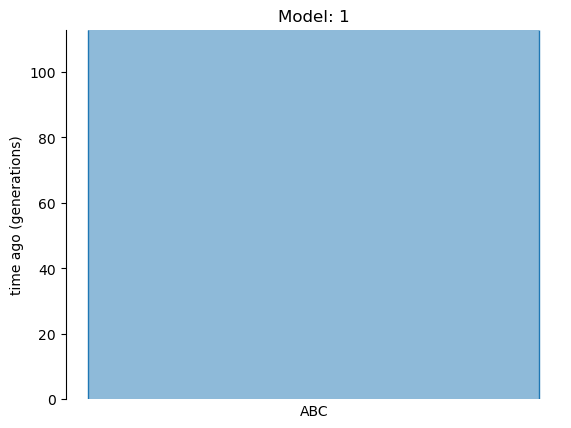

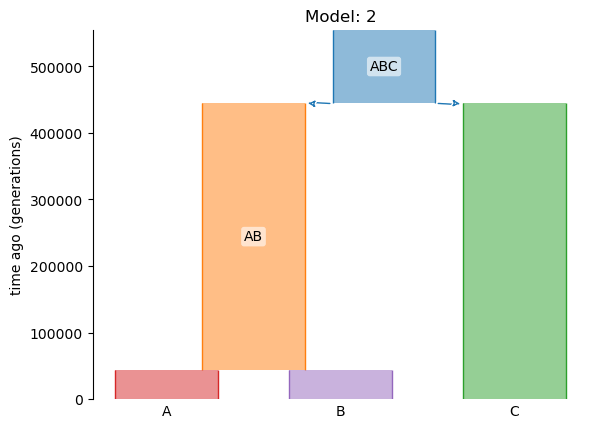

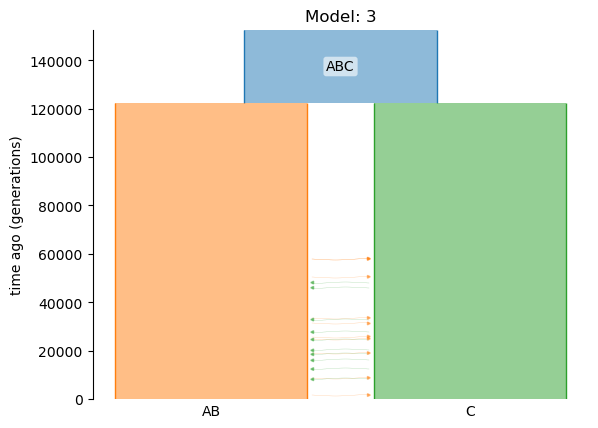

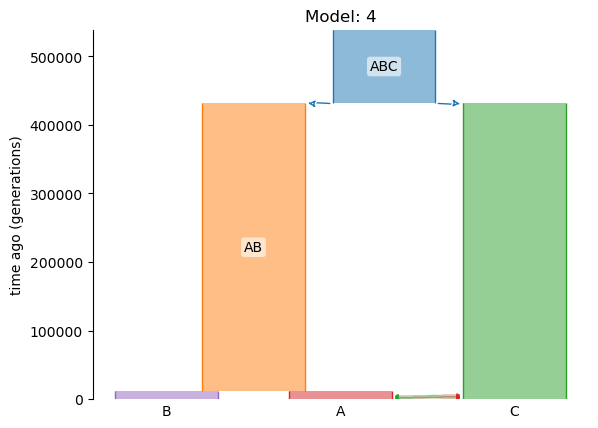

In [7]:
model_builder.validate_models(parameterized_models, labels)

## Step 5: Simulate Data

Now that we have processed our empirical data and build our models, we are ready to simulate the data that we will use to train our machine learning algorithms. We will use information from processing our empirical data (the number of individuals and SNPs to use when bulding the SFS).

In [8]:
data_simulator = simulate_data.DataSimulator(parameterized_models, labels, config=config_values, cores=1, downsampling=downsampling_dictionary, max_sites = average_snps)

arrays = data_simulator.simulate_ancestry() # simulate ancestry in msprime

INFO:delimitpy.simulate_data:Simulation execution time: 546.5842881202698 seconds.
INFO:delimitpy.simulate_data:Median simulated data has 1451 SNPs, and your input has 1053 SNPs.If these numbers are very different, you may want to change some priors.


## Step 6: Build SFS from simulated data

Now, we will create a numpy array and build jSFS and mSFS from our simulated data.

In [10]:
mSFS = data_simulator.mutations_to_sfs(arrays) # generate mSFS
jSFS = data_simulator.mutations_to_2d_sfs(arrays) # generate 2D SFS

## Step 7: Train Classifiers

We now have our simulated training data and are ready to train our classifiers. We will train three classifiers.
1) A Random Forest classifier that takes as input the bins of the multidimensional SFS (mSFS).
2) A Fully Connected Neural Network that takes as input the bins of the multidimensional SFS (mSFS).
3) A Convolutional Neural Network that takes as input the jSFS between all pairs of populations.

### Step 7a: Train the RF classifier

The code will return the model and the confusion matrix and will print the out-of-bag error rates and the confusion matrix on the validation data.

Out-of-Bag (OOB) Error: 0.015000000000000013
Cross-validation scores: [0.978 0.984]


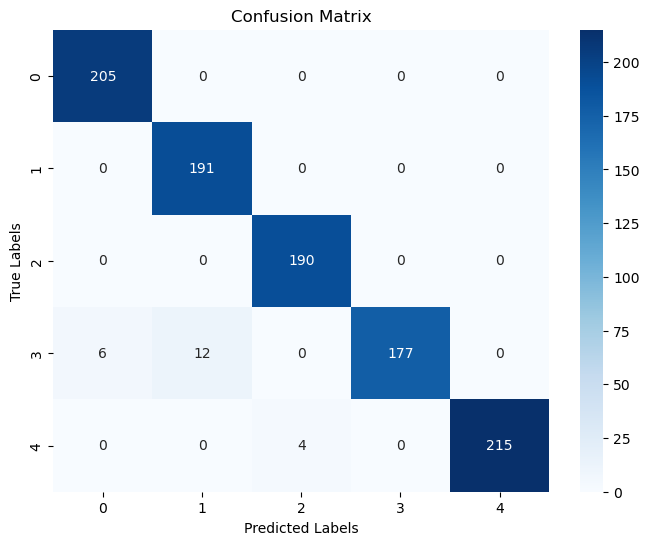

In [11]:
random_forest_sfs_predictor = build_predictors.RandomForestsSFS(config_values, mSFS, labels)
random_forest_sfs_model, random_forest_sfs_cm, random_forest_sfs_cm_plot = random_forest_sfs_predictor.build_rf_sfs()
random_forest_sfs_cm_plot.show()

### Step 7b: Train the FCNN

2024-04-06 09:30:10.033334: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
400/400 [==============================] - 2s 4ms/step - loss: 0.1314 - accuracy: 0.9665 - val_loss: 0.0760 - val_accuracy: 0.9850
Epoch 2/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0137 - accuracy: 0.9965 - val_loss: 0.0833 - val_accuracy: 0.9860
Epoch 3/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0025 - accuracy: 0.9998 - val_loss: 0.0850 - val_accuracy: 0.9860
Epoch 4/10
400/400 [==============================] - 2s 4ms/step - loss: 8.0076e-04 - accuracy: 0.9998 - val_loss: 0.0949 - val_accuracy: 0.9840
Epoch 5/10
400/400 [==============================] - 2s 4ms/step - loss: 9.5879e-04 - accuracy: 0.9998 - val_loss: 0.1249 - val_accuracy: 0.9850
Epoch 6/10
400/400 [==============================] - 2s 4ms/step - loss: 2.1271e-04 - accuracy: 1.0000 - val_loss: 0.1111 - val_accuracy: 0.9880
Epoch 7/10
400/400 [==============================] - 2s 4ms/step - loss: 9.2676e-05 - accuracy: 1.0000 - val_loss: 0.1209 - val_accurac

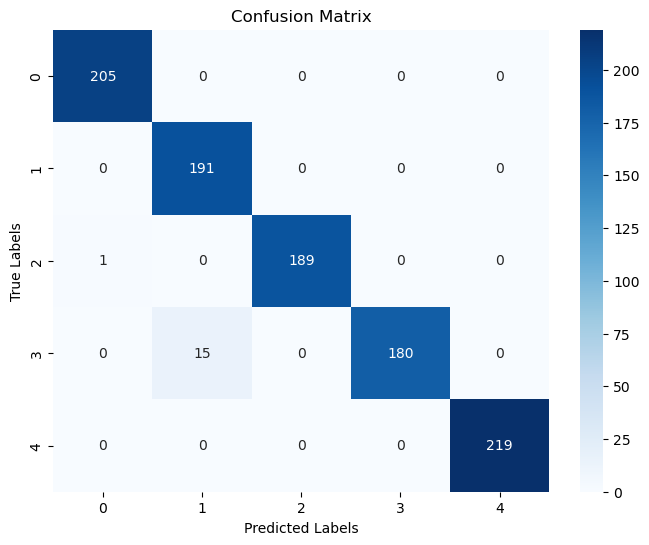

In [12]:
neural_network_sfs_predictor = build_predictors.NeuralNetSFS(config_values, mSFS, labels)
neural_network_sfs_model, neural_network_sfs_cm, neural_network_sfs_cm_plot = neural_network_sfs_predictor.build_neuralnet_sfs()
neural_network_sfs_cm_plot.show()

### Step 7c: Train the CNN

Epoch 1/10
400/400 [==============================] - 3s 6ms/step - loss: 0.1986 - accuracy: 0.9463 - val_loss: 0.0736 - val_accuracy: 0.9800
Epoch 2/10
400/400 [==============================] - 2s 5ms/step - loss: 0.0297 - accuracy: 0.9915 - val_loss: 0.0738 - val_accuracy: 0.9820
Epoch 3/10
400/400 [==============================] - 2s 5ms/step - loss: 0.0164 - accuracy: 0.9950 - val_loss: 0.1120 - val_accuracy: 0.9830
Epoch 4/10
400/400 [==============================] - 2s 5ms/step - loss: 0.0252 - accuracy: 0.9923 - val_loss: 0.1044 - val_accuracy: 0.9780
Epoch 5/10
400/400 [==============================] - 2s 5ms/step - loss: 0.0594 - accuracy: 0.9908 - val_loss: 0.1188 - val_accuracy: 0.9810
Epoch 6/10
400/400 [==============================] - 2s 5ms/step - loss: 0.0044 - accuracy: 0.9985 - val_loss: 0.1356 - val_accuracy: 0.9820
Epoch 7/10
400/400 [==============================] - 2s 5ms/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.1404 - val_accuracy: 0.9810
Epoch 

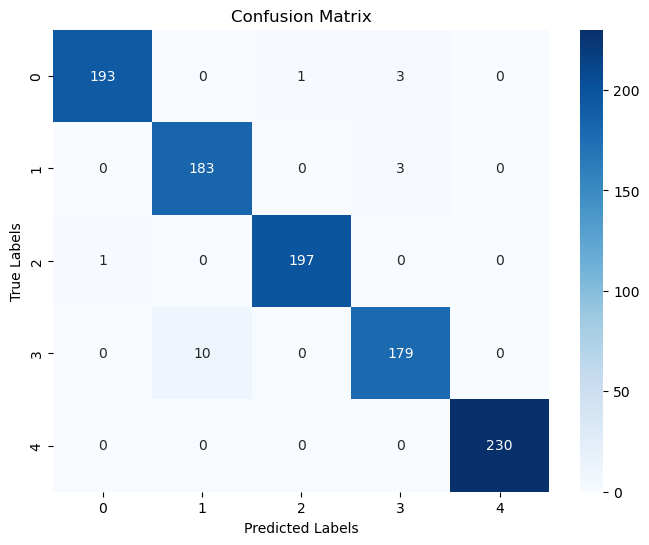

In [13]:
cnn_2d_sfs_predictor = build_predictors.CnnSFS(config_values, jSFS, labels)
cnn_2d_sfs_model, cnn_2d_sfs_cm, cnn_2d_sfs_cm_plot = cnn_2d_sfs_predictor.build_cnn_sfs()
cnn_2d_sfs_cm_plot.show()

## Step 8: Now, we are ready to apply our classifiers to our empirical data.

We will use the three classifiers trained above to make predictions on our empirical data.

### Step 8a: Random Forest predictions

In [14]:
results_rf = random_forest_sfs_predictor.predict(random_forest_sfs_model, empirical_msfs)
print(results_rf)

╒═════════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╕
│             │   Model 0 │   Model 1 │   Model 2 │   Model 3 │   Model 4 │
╞═════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Replicate 1 │         0 │         0 │         1 │         0 │         0 │
╘═════════════╧═══════════╧═══════════╧═══════════╧═══════════╧═══════════╛


### Step 8b: FCNN predictions

In [15]:
results_fcnn = neural_network_sfs_predictor.predict(neural_network_sfs_model, empirical_msfs)
print(results_fcnn)

1/1 [==============================] - 0s 34ms/step
╒═════════════╤═════════════╤═════════════╤═══════════╤═════════════╤═══════════╕
│             │     Model 0 │     Model 1 │   Model 2 │     Model 3 │   Model 4 │
╞═════════════╪═════════════╪═════════════╪═══════════╪═════════════╪═══════════╡
│ Replicate 1 │ 1.22845e-06 │ 3.86712e-17 │  0.999999 │ 2.45939e-13 │ 2.103e-11 │
╘═════════════╧═════════════╧═════════════╧═══════════╧═════════════╧═══════════╛


### Step 8c: CNN predictions

In [16]:
results_cnn = cnn_2d_sfs_predictor.predict(cnn_2d_sfs_model, empirical_2d_sfs)
print(results_cnn)

1/1 [==============================] - 0s 39ms/step
╒═════════════╤═════════════╤═════════════╤═══════════╤════════════╤═════════════╕
│             │     Model 0 │     Model 1 │   Model 2 │    Model 3 │     Model 4 │
╞═════════════╪═════════════╪═════════════╪═══════════╪════════════╪═════════════╡
│ Replicate 1 │ 1.77093e-09 │ 3.27355e-21 │         1 │ 1.3266e-25 │ 1.21563e-13 │
╘═════════════╧═════════════╧═════════════╧═══════════╧════════════╧═════════════╛
